In [1]:
!pip install transformers

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/20/5c/244db59e074e80248fdfa60495eeee257e4d97c3df3487df68be30cd60c8/transformers-4.42.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.23.2 from https://files.pythonhosted.org/packages/69/d6/73f9d1b7c4da5f0544bc17680d0fa9932445423b90cd38e1ee77d001a4f5/huggingface_hub-0.23.4-py3-none-any.whl.metadata
  Using cached huggingface_hub-0.23.4-py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for regex!=2019.12.17 from https://files.pythonhosted.org/packages/07/17/5d92509b4dccacf9767d8607112c19667e15db2428014440bae4356b8aff/regex-2024.5.15-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached regex-2024.5.15-cp310-cp310-manylinux

In [2]:
!pip install timm

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/fe/85/834c70052b518bb8fca457d8ea4e60a65d9cc41f77fd409eeff3b3041638/timm-1.0.7-py3-none-any.whl.metadata
  Using cached timm-1.0.7-py3-none-any.whl.metadata (47 kB)
Using cached timm-1.0.7-py3-none-any.whl (2.3 MB)


In [3]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


In [4]:
!pip install transformers torch torchvision pycocotools

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/6a/03/6c0bf810a5df7876caaf11f5b113e7ffd4b2fa9767d360489c6fdcefe8e5/pycocotools-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached pycocotools-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
Using cached pycocotools-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (427 kB)


In [5]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os
from tqdm import tqdm
import json

# Initialize COCO ground truth api
coco_gt = COCO('coco_trainvalann2017/annotations/instances_val2017.json')

# Load COCO validation dataset and limit to the first 1000 images
img_ids = coco_gt.getImgIds()[:200]
img_dir = 'coco_val2017/val2017'

# Initialize the model and processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

# Prepare to collect results for evaluation
detections = []

for img_id in tqdm(img_ids, desc="Processing images"):
    # Load image
    img_info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    image = Image.open(img_path)

    # Process image and make predictions
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # Post-process results
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    # Convert results to COCO format
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        detection = {
            "image_id": img_id,
            "category_id": label.item(),
            "bbox": [box[0], box[1], box[2] - box[0], box[3] - box[1]],
            "score": score.item()
        }
        detections.append(detection)

# Save the results in COCO json format
with open('detections_results.json', 'w') as f:
    json.dump(detections, f)

# Load results into COCO and evaluate
coco_dt = coco_gt.loadRes('detections_results.json')
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

# Running evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


Processing images: 100%|██████████| 200/200 [01:40<00:00,  1.99it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.41s).
Accumulating evaluation results...
DONE (t=0.94s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


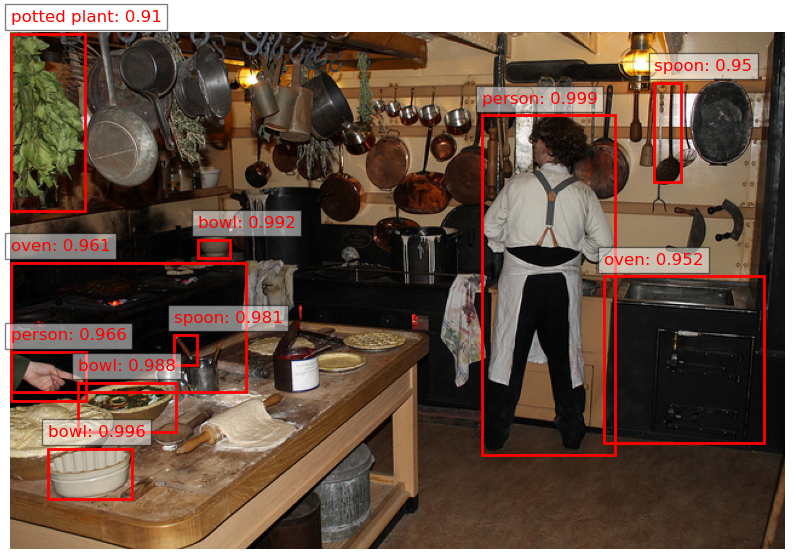

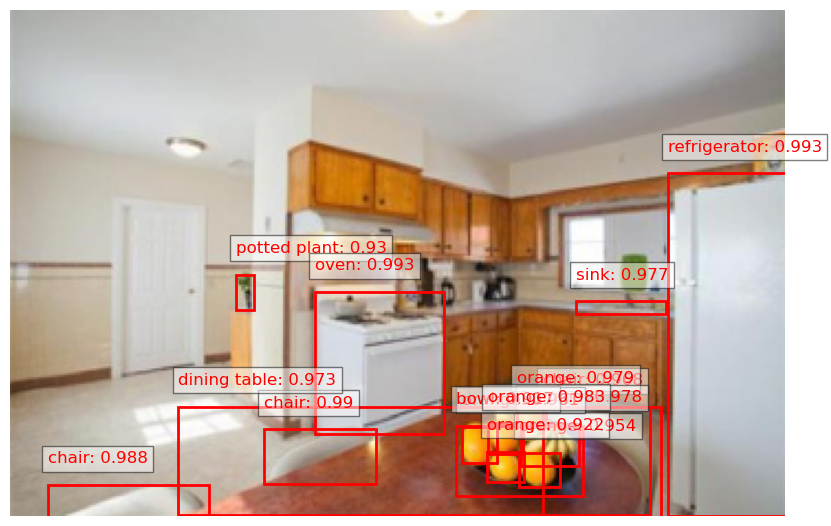

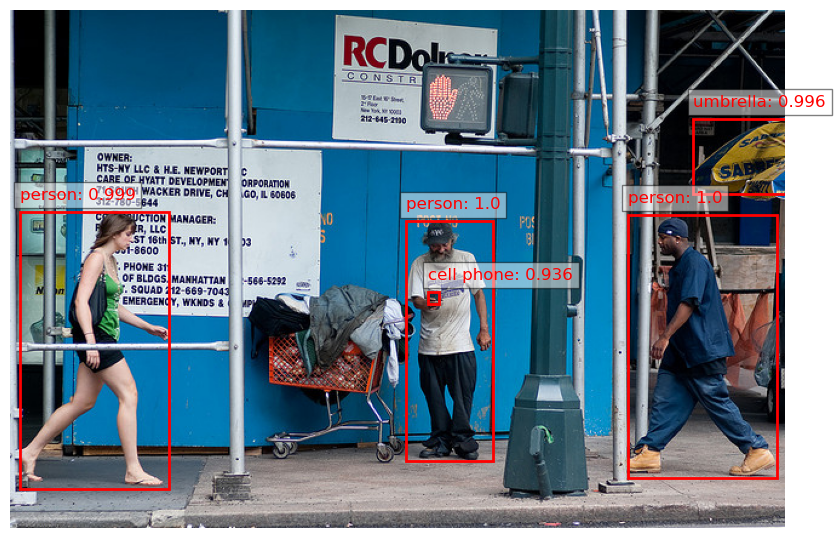

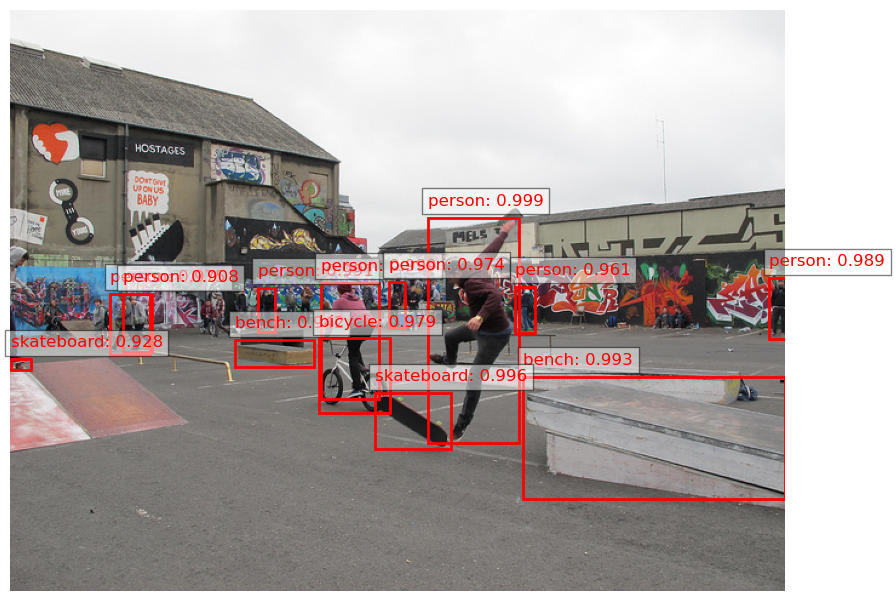

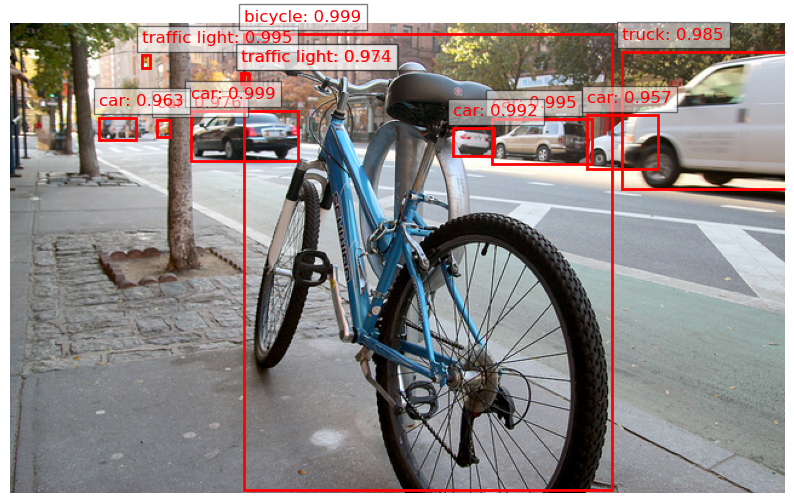

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
from pycocotools.coco import COCO
import requests
import os

# Initialize COCO ground truth api
coco_gt = COCO('coco_trainvalann2017/annotations/instances_val2017.json')

# Load COCO validation dataset and limit to the first 200 images
img_ids = coco_gt.getImgIds()[:200]
img_dir = 'coco_val2017/val2017'

# Initialize the model and processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

def visualize_predictions(image_path, results, model):
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        color = 'r'
        bbox = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(xmin, ymin - 10, f'{model.config.id2label[label.item()]}: {round(score.item(), 3)}', color=color, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.show()

# Visualize predictions for the first 5 images
for img_id in img_ids[:5]:
    img_info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    image = Image.open(img_path)
    
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    visualize_predictions(img_path, results, model)


In [7]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import numpy as np
import torch
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os
from tqdm import tqdm
import json

# Initialize COCO ground truth api
coco_gt = COCO('coco_trainvalann2017/annotations/instances_val2017.json')

# Load COCO validation dataset and limit to the first 200 images
img_ids = coco_gt.getImgIds()[:200]
img_dir = 'coco_val2017/val2017'

# Initialize the model and processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

# Prepare to collect results for evaluation
detections = []

for img_id in tqdm(img_ids, desc="Processing images"):
    # Load image
    img_info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    image = Image.open(img_path)

    # Process image and make predictions
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # Post-process results
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    # Convert results to COCO format
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        detection = {
            "image_id": img_id,
            "category_id": label.item(),
            "bbox": [box[0], box[1], box[2] - box[0], box[3] - box[1]],
            "score": score.item()
        }
        detections.append(detection)

# Save the results in COCO json format
with open('detections_results.json', 'w') as f:
    json.dump(detections, f)

# Load results into COCO and evaluate
coco_dt = coco_gt.loadRes('detections_results.json')
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

# Running evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Detailed evaluation metrics
def print_detailed_metrics(coco_eval):
    # IoU thresholds
    iou_thresh = np.linspace(0.5, 0.95, 10)
    
    print("\nDetailed Metrics")
    print("================")
    for i, thr in enumerate(iou_thresh):
        print(f"Average Precision (AP) @[ IoU={thr:.2f} | area=all | maxDets=100 ] = {coco_eval.stats[1+i]:.3f}")
    
    # Other detailed metrics
    print("\nArea-specific metrics")
    areas = ['all', 'small', 'medium', 'large']
    area_ids = [0, 1, 2, 3]
    for i, area in zip(area_ids, areas):
        print(f"Average Precision (AP) @[ IoU=0.50:0.95 | area={area} | maxDets=100 ] = {coco_eval.stats[4+i]:.3f}")
        print(f"Average Recall (AR) @[ IoU=0.50:0.95 | area={area} | maxDets=1 ] = {coco_eval.stats[8+i]:.3f}")
        print(f"Average Recall (AR) @[ IoU=0.50:0.95 | area={area} | maxDets=10 ] = {coco_eval.stats[12+i]:.3f}")
        print(f"Average Recall (AR) @[ IoU=0.50:0.95 | area={area} | maxDets=100 ] = {coco_eval.stats[16+i]:.3f}")

print_detailed_metrics(coco_eval)


loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


Processing images: 100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.10s).
Accumulating evaluation results...
DONE (t=0.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

IndexError: index 12 is out of bounds for axis 0 with size 12

In [8]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os
from tqdm import tqdm
import json
import numpy as np

# Initialize COCO ground truth api
coco_gt = COCO('coco_trainvalann2017/annotations/instances_val2017.json')

# Load COCO validation dataset and limit to the first 100 images
img_ids = coco_gt.getImgIds()[:100]
img_dir = 'coco_val2017/val2017'

# Initialize the model and processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

# Prepare to collect results for evaluation
detections = []

for img_id in tqdm(img_ids, desc="Processing images"):
    # Load image
    img_info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    image = Image.open(img_path)

    # Process image and make predictions
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # Post-process results
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    # Convert results to COCO format
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        detection = {
            "image_id": img_id,
            "category_id": label.item(),
            "bbox": [box[0], box[1], box[2] - box[0], box[3] - box[1]],
            "score": score.item()
        }
        detections.append(detection)

# Save the results in COCO json format
with open('detections_results.json', 'w') as f:
    json.dump(detections, f)

# Load results into COCO and evaluate
coco_dt = coco_gt.loadRes('detections_results.json')
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

# Running evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Detailed evaluation metrics
def print_detailed_metrics(coco_eval):
    # IoU thresholds
    iou_thresh = np.linspace(0.5, 0.95, 10)
    
    print("\nDetailed Metrics")
    print("================")
    for i, thr in enumerate(iou_thresh):
        if i < len(coco_eval.stats):
            print(f"Average Precision (AP) @[ IoU={thr:.2f} | area=all | maxDets=100 ] = {coco_eval.stats[1+i]:.3f}")
    
    # Other detailed metrics
    print("\nArea-specific metrics")
    areas = ['all', 'small', 'medium', 'large']
    area_ids = [0, 1, 2, 3]
    ap_base_idx = 1 + len(iou_thresh)  # base index for AP area-specific metrics
    ar_base_idx = ap_base_idx + len(areas)  # base index for AR area-specific metrics
    for i, area in zip(area_ids, areas):
        if ap_base_idx + i < len(coco_eval.stats):
            print(f"Average Precision (AP) @[ IoU=0.50:0.95 | area={area} | maxDets=100 ] = {coco_eval.stats[ap_base_idx + i]:.3f}")
        if ar_base_idx + i < len(coco_eval.stats):
            print(f"Average Recall (AR) @[ IoU=0.50:0.95 | area={area} | maxDets=1 ] = {coco_eval.stats[ar_base_idx + i]:.3f}")
        if ar_base_idx + len(areas) + i < len(coco_eval.stats):
            print(f"Average Recall (AR) @[ IoU=0.50:0.95 | area={area} | maxDets=10 ] = {coco_eval.stats[ar_base_idx + len(areas) + i]:.3f}")
        if ar_base_idx + 2 * len(areas) + i < len(coco_eval.stats):
            print(f"Average Recall (AR) @[ IoU=0.50:0.95 | area={area} | maxDets=100 ] = {coco_eval.stats[ar_base_idx + 2 * len(areas) + i]:.3f}")

print_detailed_metrics(coco_eval)


loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


Processing images: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.39s).
Accumulating evaluation results...
DONE (t=0.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10